In [1]:

from datetime import datetime
import pytz
print('LOGGING TIME OF START:',  datetime.strftime(datetime.now(pytz.timezone('Asia/Singapore')), "%Y-%m-%d %H:%M:%S"))

import sys
sys.path.append('../input/hengck-czii-cryo-et-01')

from czii_helper import *
from dataset import *
from model2 import *
import numpy as np
from scipy.optimize import linear_sum_assignment
import glob
import cc3d
import cv2


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


print('IMPORT OK!!!')

LOGGING TIME OF START: 2025-01-27 19:55:15
IMPORT OK!!!


In [2]:
DATA_KAGGLE_DIR = '../input/czii-cryo-et-object-identification'

MODE='local'

if MODE=='local':
    valid_dir =f'{DATA_KAGGLE_DIR}/train'
    valid_id = ['TS_73_6', ]
    
if MODE=='submit':
    valid_dir =f'{DATA_KAGGLE_DIR}/test' 
    valid_id = glob.glob(f'{valid_dir}/static/ExperimentRuns/*')
    valid_id = [f.split('/')[-1] for f in valid_id]
    
print('valid_id:',len(valid_id), valid_id)

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '../model/resnet34d.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

print('MODE:', MODE)
print('SETTING OK!!!')

valid_id: 1 ['TS_73_6']
MODE: local
SETTING OK!!!


In [4]:
net = Net(pretrained=False, cfg=cfg)
state_dict = torch.load(cfg.checkpoint, map_location=lambda storage, loc: storage)['state_dict']
print(net.load_state_dict(state_dict, strict=False))

print(net.arch)
print('MODEL OK!!!')

/tmp/ipykernel_1082405/2774253390.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cfg.checkpoint, map_location=lambda storage, loc: storage)['sta

<All keys matched successfully>
resnet34d
MODEL OK!!!


In [5]:
def probability_to_location(probability,cfg):
    _,D,H,W = probability.shape

    location={}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(probability[l]>cfg.threshold[p.name], return_N=True)
        stats = cc3d.statistics(cc)
        zyx=stats['centroids'][1:]*10
        xyz = np.ascontiguousarray(zyx[:,::-1]) 
        location[p.name]=xyz
        '''
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        '''
    return location

def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz)>0:
            df = pd.DataFrame(data=xyz, columns=['x','y','z'])
            #df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column='particle_type', value=p.name)
            location_df.append(df)
    location_df = pd.concat(location_df)
    return location_df


#start here !!!! ====================================================================================
def run_submit():
    
    net.cuda()
    net.eval()
    net.output_type = ['infer']

    submit_df = []
    start_timer = timer()
    for i,id in enumerate(valid_id):
        print(i, id, '---------------')
        volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
        D, H, W = volume.shape
        print(D, H, W)

        probability = np.zeros((7, D, H, W), dtype=np.float32)
        count = np.zeros((7, D, H, W), dtype=np.float32)
        pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
        
        num_slice=64
        zz = list(range(0, D - num_slice, num_slice//2)) + [D - num_slice]
        for z in zz:
            print('\r',f'z:{z}', end='',flush=True)
            image = pad_volume[z:z + num_slice]
            batch = dotdict(
                image=torch.from_numpy(image).unsqueeze(0),
            )
            with torch.amp.autocast('cuda', enabled=True):
                with torch.no_grad():
                    output = net(batch)
            prob = output['particle'][0].cpu().numpy()
            probability[:, z:z + num_slice] += prob[:, :, :H, :W]
            count[:, z:z + num_slice] += 1
        probability = probability / (count + 0.0001)
        location = probability_to_location(probability, cfg)
        df = location_to_df(location)
        df.insert(loc=0, column='experiment', value=id)
        submit_df.append(df)
        print('')
        print(time_to_str(timer() - start_timer, 'sec'))

    print('\ndone!')
    total_time = timer() - start_timer
    num_volume = len(valid_id)
    print(f'Total time for {num_volume} volumes:', time_to_str(total_time, 'min'))
    print(f'Total time for 500 volumes:', time_to_str(total_time/num_volume*500, 'min'))
    print('')
    submit_df = pd.concat(submit_df)
    submit_df.insert(loc=0, column='id', value=np.arange(len(submit_df)))
    return submit_df



if 1:
    submit_df = run_submit()
    print('submit_df', submit_df.shape)
    print(submit_df)
    submit_df.to_csv('submission.csv', index=False)

#!ls
print('SUBMIT OK!!!')

0 TS_73_6 ---------------
184 630 630
 z:120
 0 min 13 sec

done!
Total time for 1 volumes:  0 hr 00 min
Total time for 500 volumes:  1 hr 49 min

submit_df (13, 6)
   id experiment       particle_type            x            y            z
0   0    TS_73_6        apo-ferritin  5409.333333  4618.000000    64.666667
1   1    TS_73_6        apo-ferritin  4618.150685  2436.027397   109.178082
2   2    TS_73_6        apo-ferritin  2343.660714  2559.553571   222.946429
3   3    TS_73_6        apo-ferritin  2800.000000  1310.370370   244.444444
4   4    TS_73_6        apo-ferritin   615.833333  1990.000000   528.333333
5   5    TS_73_6        apo-ferritin  1643.488372   539.767442   574.651163
6   6    TS_73_6        apo-ferritin  4289.777778  2534.111111   613.333333
7   7    TS_73_6        apo-ferritin   240.000000  4851.250000   901.250000
8   8    TS_73_6        apo-ferritin   578.658537  2770.243902  1070.853659
0   9    TS_73_6  beta-galactosidase  2950.000000  1918.125000    46.250000

['TS_73_6']
 TS_73_6 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  9  95    9    86   0        1.0  0.094737  0.100065   
1         beta-amylase  0  12    0    12   0        0.0  0.000000  0.000000   
2   beta-galactosidase  4  14    0    14   4        0.0  0.000000  0.000000   
3             ribosome  0  46    0    46   0        0.0  0.000000  0.000000   
4        thyroglobulin  0  28    0    28   0        0.0  0.000000  0.000000   
5  virus-like-particle  0  22    0    22   0        0.0  0.000000  0.000000   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.014295057460525088

TS_73_6 apo-ferritin
	 num truth   : 95
	 num predict : 9
	 num hit  : 9
	 num fp   : 0
	 num miss : 86
TS_73_6 beta-amylase
	 num truth   : 12
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 12
TS_73_6 beta-galactosidase
	 num truth   : 14
	 num predict : 4
	 num hit  : 0
	 

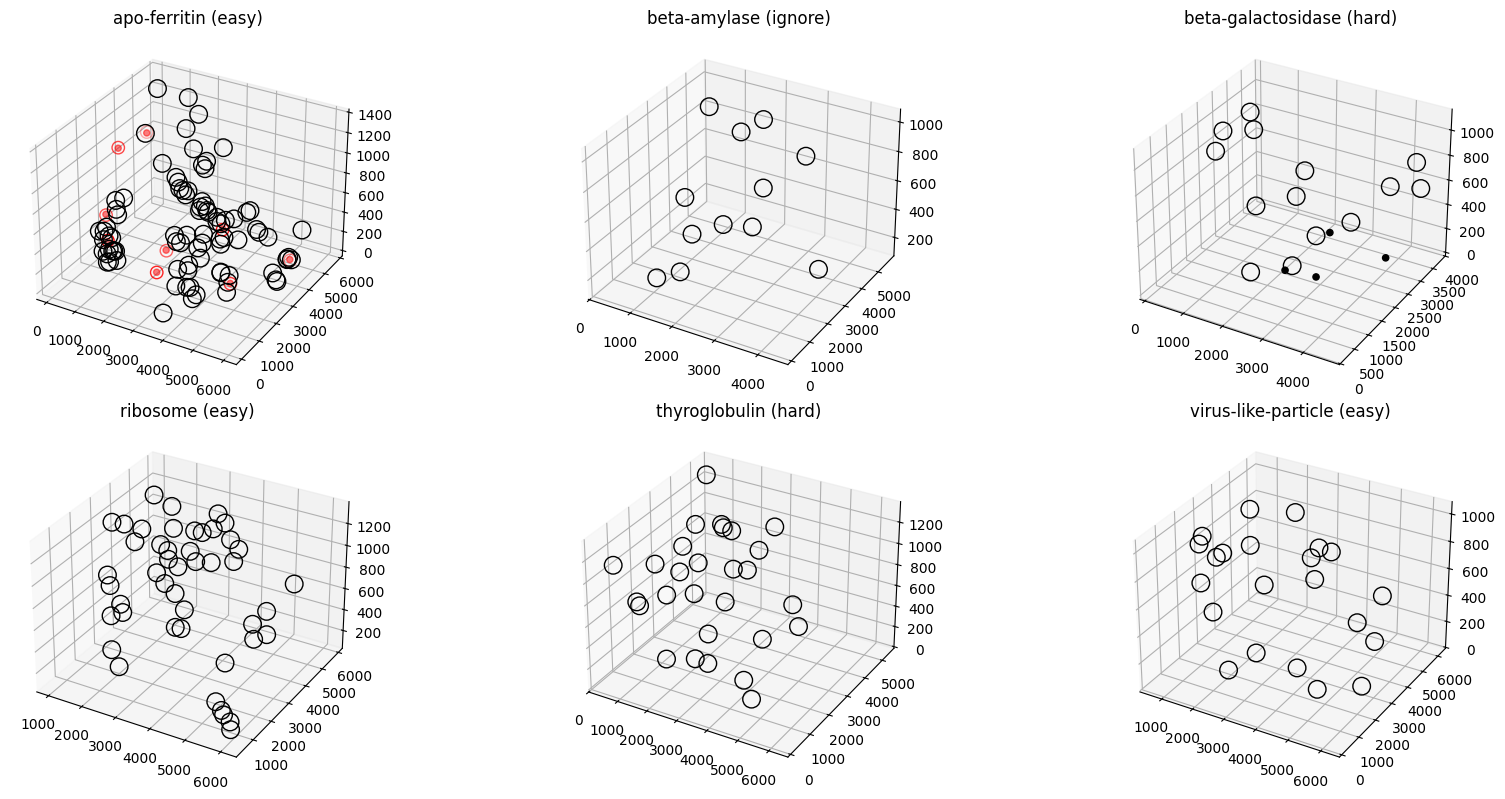

In [6]:
def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0